In [1]:
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchinfo import summary

In [2]:
root_dir = "/unix/erw/data/24-07-25/batch_output"
root_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(".root")]

all_elements = set()
for path in root_files:
    with uproot.open(path) as file:
        # set(elements)
        df = file["Materials"].arrays(library="pd")
        all_elements.update(df["Element"].unique())
        
element_list = sorted(list(all_elements))
print(element_list)
element_to_index = {el: i for i, el in enumerate(element_list)}


X = [] 
Y = [] 

for path in root_files:
    with uproot.open(path) as file:

        spectrum = file["Edep (noise)"].values()
        #spectrum = file["Edep"].values()

        # min-max scale normalization
        spectrum_min = np.min(spectrum)
        spectrum_max = np.max(spectrum)
        if spectrum_max > spectrum_min:
            spectrum = (spectrum - spectrum_min) / (spectrum_max - spectrum_min)
        else:
            spectrum = np.zeros_like(spectrum)

        spectrum = spectrum.astype(np.float32)
        X.append(spectrum)

        df = file["Materials"].arrays(library="pd")
        df = df.drop_duplicates()           # Don't forget!!!
        target = np.zeros(len(element_list), dtype=np.float32)
        for _, row in df.iterrows():
            idx = element_to_index[row["Element"]]
            target[idx] += row["Fraction"]
        Y.append(target)


X = torch.tensor(np.stack(X)).unsqueeze(1)  # shape: [N, 1, 1440]
Y = torch.tensor(np.stack(Y))               # shape: [N, num_elements]

# Check data
i = 0  

print("\nX shape:", X.shape) 
print(f"X[{i}][:20] values:\n", X[i][0][:20]) 

print("\nY shape:", Y.shape) 
print(f"Y[{i}] values:\n", Y[i])

print("\nElement：")
for idx, frac in enumerate(Y[i]):
    print(f"{element_list[idx]}: {frac.item():.4f}")

['C', 'O', 'Si']

X shape: torch.Size([1000, 1, 1440])
X[0][:20] values:
 tensor([1.0000, 0.9749, 0.9644, 0.9733, 0.8923, 0.9320, 0.9474, 0.9215, 0.8761,
        0.8955, 0.8130, 0.8761, 0.7943, 0.7927, 0.8089, 0.8138, 0.8081, 0.7806,
        0.7522, 0.7312])

Y shape: torch.Size([1000, 3])
Y[0] values:
 tensor([0.0464, 0.5079, 0.4457])

Element：
C: 0.0464
O: 0.5079
Si: 0.4457


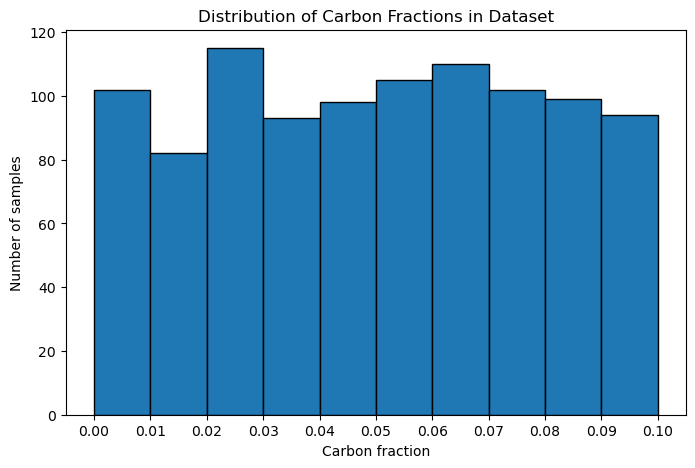

In [3]:
carbon_fractions = Y[:, 0].numpy()

bins = [i/100 for i in range(11)]

plt.figure(figsize=(8, 5))
plt.hist(carbon_fractions, bins=bins, edgecolor="black")
plt.xlabel("Carbon fraction")
plt.ylabel("Number of samples")
plt.title("Distribution of Carbon Fractions in Dataset")
plt.xticks(bins)
plt.show()

In [4]:
class cCNN_MDN(nn.Module):
    def __init__(self, num_elements=3, num_mixtures=3):
        super().__init__()
        self.num_elements = num_elements  # D: C, O, Si
        self.num_mixtures = num_mixtures  # M

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, padding=4),   # [B, 64, 1440]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 64, 360]

            nn.Conv1d(64, 128, kernel_size=7, padding=3), # [B, 128, 360]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4),                  # [B, 128, 90]
        )

        self.flatten_dim = 128 * 90 # depends on input shape

        self.hidden = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )

        # Output layers
        self.pi_layer = nn.Linear(64, num_mixtures)                          # [B, M]
        self.mu_layer = nn.Linear(64, num_mixtures * num_elements)           # [B, M*D]
        self.sigma_layer = nn.Linear(64, num_mixtures * num_elements)        # [B, M*D]

    def forward(self, x):
        B = x.size(0)
        x = self.conv_layers(x)
        x = x.view(B, -1)
        x = self.hidden(x)

        # MDN parameters
        pi = F.softmax(self.pi_layer(x), dim=1)                              # [B, M]

        mu = self.mu_layer(x).view(B, self.num_mixtures, self.num_elements)  # [B, M, D]

        sigma = torch.exp(self.sigma_layer(x).view(B, self.num_mixtures, self.num_elements))  # [B, M, D]
        return pi, mu, sigma

In [5]:
def logit_transform(c, eps=1e-6):
    """Logit transform for C fraction"""
    c = torch.clamp(c, eps, 1 - eps)
    return torch.log(c / (1 - c))

def logit_inverse(logit_c):
    """Inverse logit (sigmoid) transform for C"""
    return torch.sigmoid(logit_c)

In [6]:
def compute_log_likelihood_logitC(y, pi, mu, sigma, eps=1e-6):
    """
    Compute log-likelihood for logit(C), O, Si
    Only the first dimension (C) is logit-transformed in both target and prediction.
    """
    B, M, D = mu.shape

    # Transform target C to logit
    y_logit_c = logit_transform(y[:, 0], eps=eps)  # shape: [B]
    y_other = y[:, 1:]                             # shape: [B, 2]
    y_transformed = torch.cat([y_logit_c.unsqueeze(1), y_other], dim=1)  # [B, 3]

    # Expand to match mixtures
    y_expanded = y_transformed.unsqueeze(1).expand(-1, M, -1)  # [B, M, D]

    # Compute log-likelihood
    normalizer = torch.sqrt(torch.tensor(2.0 * torch.pi, device=y.device))
    coef = 1.0 / (normalizer * sigma + eps)
    exponent = -0.5 * ((y_expanded - mu) / (sigma + eps)) ** 2
    probs = coef * torch.exp(exponent)  # [B, M, D]
    probs = torch.prod(probs, dim=2)    # [B, M]

    weighted_probs = probs * pi         # [B, M]
    total_prob = torch.sum(weighted_probs, dim=1) + eps  # [B]
    log_likelihoods = torch.log(total_prob)  # [B]
    return log_likelihoods


def mdn_loss(y, pi, mu, sigma, eps=1e-6):
    log_likelihood = compute_log_likelihood_logitC(y, pi, mu, sigma, eps)
    return -torch.mean(log_likelihood)


def mdn_loss_std(y, pi, mu, sigma, alpha=5, eps=1e-6, sample_weights=None):
    nll = mdn_loss(y, pi, mu, sigma, eps)
    if sample_weights is not None:
        nll = nll * sample_weights
    nll_loss = nll.mean()

    sigma_penalty = torch.mean(torch.log(1 + 1000 * sigma))
    loss = nll_loss + alpha * sigma_penalty
    return loss

In [7]:
# Hyperparameter (grid search in future)
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [8]:
# Split dataset
dataset = TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [9]:
# Initialize model
model = cCNN_MDN(num_elements=3, num_mixtures=1)  # unstable training - only use 1 components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(batch_size, 1, 1440))

Layer (type:depth-idx)                   Output Shape              Param #
cCNN_MDN                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 128, 90]             --
│    └─Conv1d: 2-1                       [32, 64, 1440]            640
│    └─BatchNorm1d: 2-2                  [32, 64, 1440]            128
│    └─ReLU: 2-3                         [32, 64, 1440]            --
│    └─MaxPool1d: 2-4                    [32, 64, 360]             --
│    └─Conv1d: 2-5                       [32, 128, 360]            57,472
│    └─BatchNorm1d: 2-6                  [32, 128, 360]            256
│    └─ReLU: 2-7                         [32, 128, 360]            --
│    └─MaxPool1d: 2-8                    [32, 128, 90]             --
├─Sequential: 1-2                        [32, 64]                  --
│    └─Linear: 2-9                       [32, 256]                 2,949,376
│    └─ReLU: 2-10                        [32, 256]                 --
│

Epoch 1/50 | Train Loss: 1.9296 | Val Loss: 3.3065
Epoch 2/50 | Train Loss: -1.4227 | Val Loss: 1.1193
Epoch 3/50 | Train Loss: -2.4527 | Val Loss: -1.9994
Epoch 4/50 | Train Loss: -2.0126 | Val Loss: -2.4983
Epoch 5/50 | Train Loss: -3.1465 | Val Loss: -3.7866
Switching learning rate to 5e-5
Epoch 6/50 | Train Loss: -4.2765 | Val Loss: -4.9011
Epoch 7/50 | Train Loss: -4.9439 | Val Loss: -5.5178
Epoch 8/50 | Train Loss: -3.1460 | Val Loss: -5.0262
Epoch 9/50 | Train Loss: -4.8540 | Val Loss: -5.1743
Epoch 10/50 | Train Loss: -4.9417 | Val Loss: -5.5651
Epoch 11/50 | Train Loss: -4.8339 | Val Loss: -4.6760
Epoch 12/50 | Train Loss: -5.3935 | Val Loss: -5.6181
Switching learning rate to 1e-5
Epoch 13/50 | Train Loss: -5.7343 | Val Loss: -5.8514
Epoch 14/50 | Train Loss: -5.8873 | Val Loss: -5.8786
Epoch 15/50 | Train Loss: -5.9775 | Val Loss: -5.9817
Epoch 16/50 | Train Loss: -6.0564 | Val Loss: -6.0309
Epoch 17/50 | Train Loss: -6.0998 | Val Loss: -6.1532
Epoch 18/50 | Train Loss: -6.1

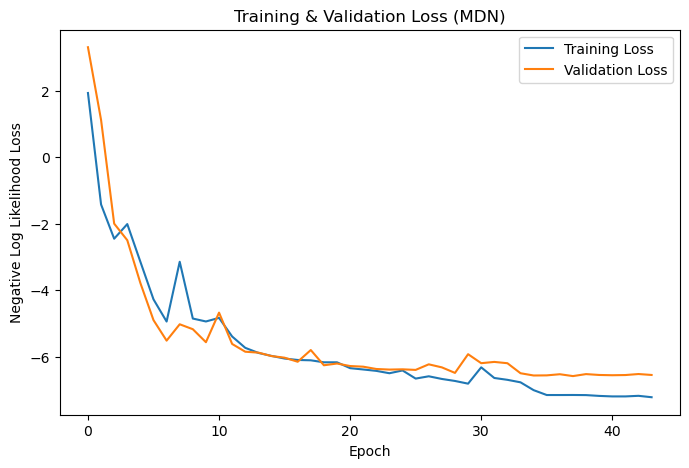

In [10]:
# Training loop
train_losses = []
val_losses = []

lr_switched_1 = False
lr_switched_2 = False
lr_switched_3 = False

gap_history = []
gap_window = 5
early_stop_triggered = False

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_Y in train_loader:
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        optimizer.zero_grad()
        pi, mu, sigma = model(batch_X)
        #sample_weights = compute_asymmetric_sample_weights(batch_Y).to(device)
        loss = mdn_loss_std(batch_Y, pi, mu, sigma, alpha=0, eps=1e-6, sample_weights=None)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_X, val_Y in val_loader:
            val_X, val_Y = val_X.to(device), val_Y.to(device)
            pi, mu, sigma = model(val_X)
            #sample_weights = compute_asymmetric_sample_weights(val_Y).to(device)
            loss = mdn_loss_std(val_Y, pi, mu, sigma, alpha=0, eps=1e-6, sample_weights=None)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping (need change!)
    gap = avg_val_loss - avg_train_loss
    gap_history.append(gap)

    if len(gap_history) > gap_window:
        gap_history.pop(0)  # only keep N recent gap value

        if epoch >= 20 and avg_val_loss <= -4:  
            # If N recent gap strictly increasing
            if all(gap_history[i] < gap_history[i + 1] for i in range(gap_window - 1)):
                print(f"Early stop at {gap_window} epochs")
                early_stop_triggered = True
                break
    
    # Switch learning rate
    if not lr_switched_1 and avg_train_loss < -3:
        print("Switching learning rate to 5e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 5e-5
        lr_switched_1 = True

    if not lr_switched_2 and avg_train_loss < -5:
        print("Switching learning rate to 1e-5")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-5
        lr_switched_2 = True

    if not lr_switched_3 and avg_train_loss < -7:
        print("Switching learning rate to 1e-6")
        for param_group in optimizer.param_groups:
            param_group['lr'] = 1e-6
        lr_switched_3 = True

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training & Validation Loss (MDN)")
plt.legend()
plt.show()

In [11]:
def mdn_predict_mean(pi, mu):
    return torch.sum(pi.unsqueeze(-1) * mu, dim=1)  # [B, D]

def mdn_predict_std(pi, mu, sigma):
    # Expected mean: E[y] = sum(pi * mu)
    mean = torch.sum(pi.unsqueeze(2) * mu, dim=1)  # shape: [B, D]

    # Variance: Var[y] = sum(pi * (sigma^2 + (mu - E[y])^2))
    var = torch.sum(
        pi.unsqueeze(2) * (sigma ** 2 + (mu - mean.unsqueeze(1)) ** 2),
        dim=1
    )  # shape: [B, D]

    std = torch.sqrt(var + 1e-8)
    return std

In [12]:
model.eval()

all_preds = []
all_targets = []
all_stds = []

all_pi = []
all_mu = []
all_sigma = []

with torch.no_grad():
    for val_X, val_Y in val_loader:
        val_X = val_X.to(device)
        val_Y = val_Y.to(device)

        pi, mu, sigma = model(val_X)            # [B, M], [B, M, D], [B, M, D]

        mu = mu.clone() 
        sigma = sigma.clone()

        # Inverse logit on mu[:, :, 0]
        mu_logit_c = mu[:, :, 0]
        mu_c = logit_inverse(mu_logit_c)

        # Transform sigma using the delta method
        sigmoid_grad = mu_c * (1 - mu_c)  # derivative of sigmoid
        sigma_c = sigmoid_grad * sigma[:, :, 0]

        # Replace C
        mu[:, :, 0] = mu_c
        sigma[:, :, 0] = sigma_c

        y_pred = mdn_predict_mean(pi, mu)       # [B, D]
        y_std = mdn_predict_std(pi, mu, sigma)  # [B, D]

        all_preds.append(y_pred.cpu())
        all_targets.append(val_Y.cpu())
        all_stds.append(y_std.cpu())

        all_pi.append(pi.cpu())
        all_mu.append(mu.cpu())
        all_sigma.append(sigma.cpu())

all_preds = torch.cat(all_preds, dim=0)         # [N, D]
all_targets = torch.cat(all_targets, dim=0)     # [N, D]
all_stds = torch.cat(all_stds, dim=0)           # [N, D]

all_pi = torch.cat(all_pi, dim=0)               # [N, M]
all_mu = torch.cat(all_mu, dim=0)               # [N, M, D]
all_sigma = torch.cat(all_sigma, dim=0)         # [N, M, D]

In [13]:
def compute_mae(y_pred, y_true):
    return torch.mean(torch.abs(y_pred - y_true))

mae = compute_mae(all_preds, all_targets)

print(f"MAE: {mae:.4f}")

MAE: 0.0110


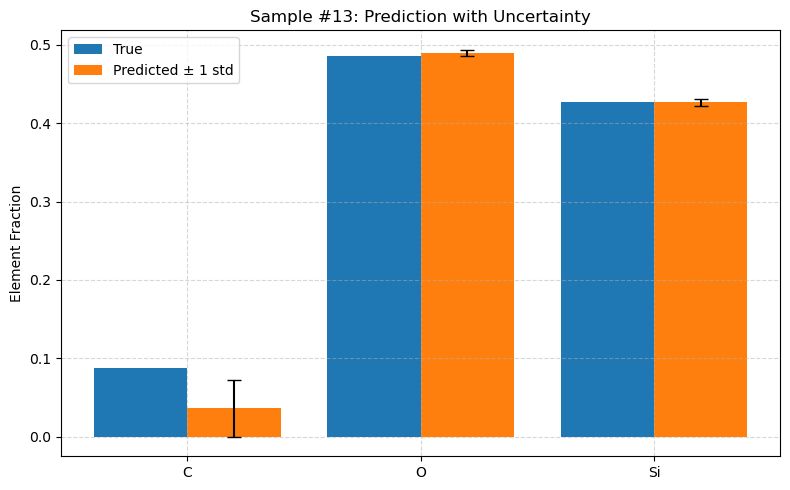

In [14]:
# Take one sample
# To see uncertainty

i = 13
x = torch.arange(len(element_list))

plt.figure(figsize=(8, 5))
plt.bar(x-0.2, all_targets[i], width=0.4, label="True")
plt.bar(x+0.2, all_preds[i], width=0.4, yerr=all_stds[i],
        capsize=5, label="Predicted ± 1 std")

plt.xticks(x, element_list)
plt.ylabel("Element Fraction")
plt.title(f"Sample #{i}: Prediction with Uncertainty")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
def gaussian_pdf(x, mu, sigma):
    """compute 1D Gaussian PDF."""
    coef = 1.0 / (np.sqrt(2 * np.pi) * sigma)
    exponent = np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return coef * exponent

def plot_mdn_distribution(idx, d, all_pi, all_mu, all_sigma, all_targets):
    """
    idx: sample index
    d: dimension index (e.g. 0 = C, 1 = O, 2 = Si)
    """
    pi = all_pi[idx].numpy()              # [M]
    mu = all_mu[idx, :, d].numpy()        # [M]
    sigma = all_sigma[idx, :, d].numpy()  # [M]
    y_true = all_targets[idx, d].item()

    x = np.linspace(-0.02, 0.1, 500)
    pdf = np.zeros_like(x)

    for k in range(len(pi)):
        pdf += pi[k] * gaussian_pdf(x, mu[k], sigma[k])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(x, pdf, label=f"Predicted PDF for Element {element_list[d]}", color="orange")
    plt.axvline(y_true, color="blue", linestyle="--", label="True Value")
    plt.title(f"Sample #{idx}: MDN Predicted Distribution for Element {element_list[d]}")
    plt.xlabel("Element Fraction")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

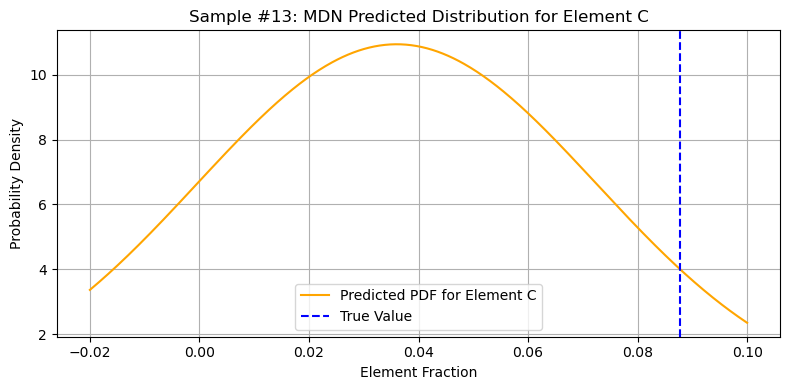

In [22]:
plot_mdn_distribution(idx=13, d=0, 
                      all_pi=all_pi,
                      all_mu=all_mu,
                      all_sigma=all_sigma,
                      all_targets=all_targets)

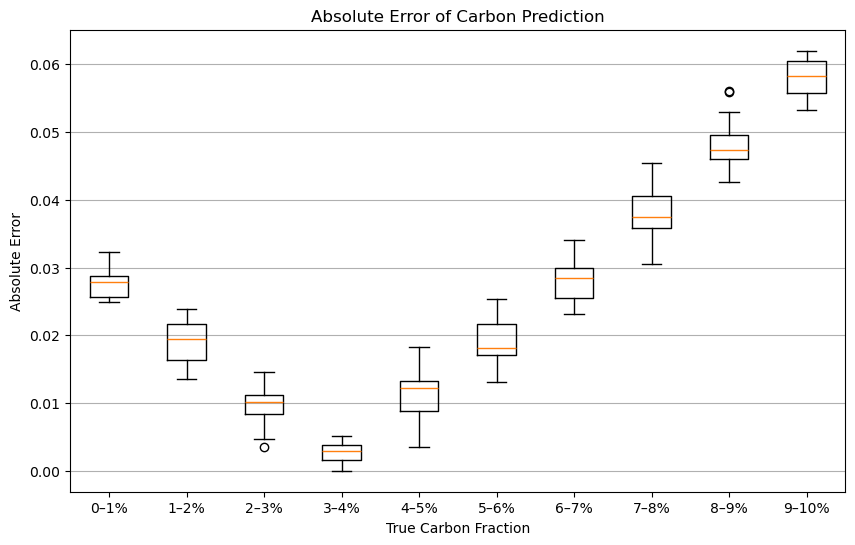

In [17]:
carbon_index = 0
true_C = all_targets[:, carbon_index].numpy()
pred_C = all_preds[:, carbon_index].numpy()
abs_errors = np.abs(true_C - pred_C)

# bins：0-1%, 1-2%, ..., 9-10%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]

# Split samples by bins
bin_indices = np.digitize(true_C, bins) - 1  # bin index from 0 to 9

# Collect abs error in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
for idx, err in zip(bin_indices, abs_errors):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)

# plot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_errors, tick_labels=bin_labels, showfliers=True)
plt.xlabel("True Carbon Fraction")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of Carbon Prediction")
plt.grid(True, axis="y")
plt.show()

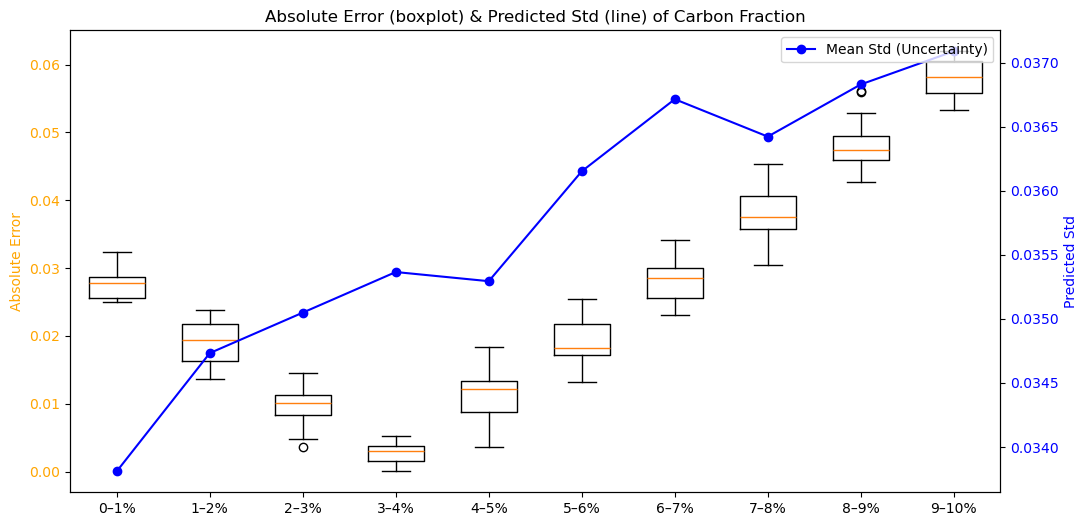

In [18]:
# Add std line plot

std_C = all_stds[:, carbon_index].numpy() 

# bins：0-10%, 10-20%, ..., 90-100%
bins = np.linspace(0, 0.1, 11)
bin_labels = [f"{int(b*100)}–{int(bins[i+1]*100)}%" for i, b in enumerate(bins[:-1])]
bin_indices = np.digitize(true_C, bins) - 1  # Bin index: 0 to 9

# Correct abs error and stf in each bin
grouped_errors = [[] for _ in range(len(bins) - 1)]
grouped_stds = [[] for _ in range(len(bins) - 1)]
for idx, err, std in zip(bin_indices, abs_errors, std_C):
    if 0 <= idx < len(grouped_errors):
        grouped_errors[idx].append(err)
        grouped_stds[idx].append(std)

# mean std for each bin
std_means = [np.mean(s) if len(s) > 0 else 0 for s in grouped_stds]
#print(std_means)
x_pos = np.arange(len(bin_labels))

# plot
# left: boxplot; right: std
fig, ax1 = plt.subplots(figsize=(12, 6))

# Boxplot for abs error
box = ax1.boxplot(grouped_errors, positions=x_pos, widths=0.6)
ax1.set_ylabel("Absolute Error", color="orange")
ax1.tick_params(axis="y", labelcolor="orange")

# Line plot for std
ax2 = ax1.twinx()
ax2.plot(x_pos, std_means, color="blue", marker="o", label="Mean Std (Uncertainty)")
ax2.set_ylabel("Predicted Std", color="blue")
ax2.tick_params(axis="y", labelcolor="blue")
ax2.legend(loc="upper right")

plt.xticks(x_pos, bin_labels)
plt.title("Absolute Error (boxplot) & Predicted Std (line) of Carbon Fraction")
plt.show()

In [19]:
residuals = (true_C - pred_C)

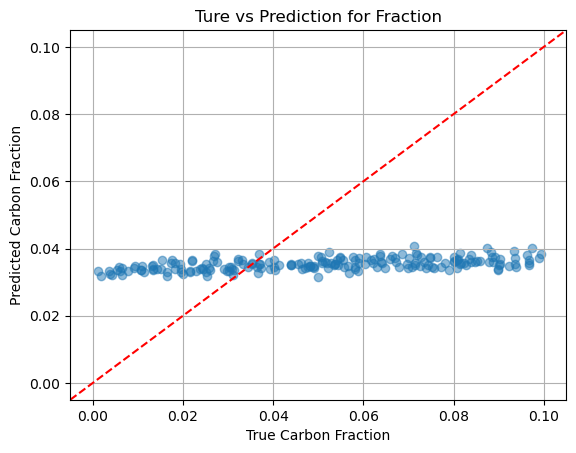

In [20]:
plt.scatter(true_C, pred_C, alpha=0.5)
plt.axline(xy1=(0.1,0.1), xy2=(0,0), color="red", linestyle="--")
plt.xlabel("True Carbon Fraction")
plt.ylabel("Predicted Carbon Fraction")
plt.title("Ture vs Prediction for Fraction")
plt.grid(True)
plt.show()